QoSBuddy

Data Acquisition and Understanding: 
starting with loading and exploring the chosen dataset from Zenodo. This dataset provides QoS metrics from 5G campus networks, including one-way delay, throughput, jitter, and packet loss, which align with our project's goals for network performance monitoring and anomaly detection.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline
plt.style.use('seaborn-darkgrid')

Since the dataset 'ntnu_owd_all_Packets.csv' is large (approximately 2.7 GB) and contains packet-level data from 5G network measurements, we'll load a sample of the first 100,000 rows for initial exploration to avoid memory issues. This allows us to inspect the structure, columns, and data types.

In [3]:
# Define the file path 
file_path = './ntnu_owd_all_Packets.csv'

# Load sample with proper handling for mixed-type IP columns
df_sample = pd.read_csv(
    file_path, 
    nrows=100000,
    dtype={'SourceIPOuter': 'string', 'DestinationIPOuter': 'string'},
    low_memory=False
)

print("Shape:", df_sample.shape)
df_sample.head()

Shape: (100000, 23)


,Unnamed: 0,src,Timestamp,SourceIPOuter,DestinationIPOuter,SourceIPInner,DestinationIPInner,PacketSize,SeqNum,iat,...,bw,slots,ratio,pdist,piat,psize,pnpak,rep,scenario,direction
0,1,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,1,0.000000,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
1,2,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,2,0.001712,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
2,3,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,3,0.001652,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
3,4,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,4,0.001694,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink
4,5,1ue,1.720191e+09,<NA>,<NA>,10.45.0.2,10.45.0.1,32,5,0.001704,...,20,10,2,det,1700,small,10000,1,oai_b200_20mhz_10slots_ratio2_det_01700_small_...,uplink


Now that the data is loaded, let's inspect its structure. This includes checking data types, non-null counts, and memory usage with .info(). We'll also list the columns for reference. This helps identify if any columns need type conversion (e.g., 'Timestamp' to datetime) or if there are missing values.

In [4]:
# Get data info
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          100000 non-null  int64  
 1   src                 100000 non-null  object 
 2   Timestamp           100000 non-null  float64
 3   SourceIPOuter       40000 non-null   string 
 4   DestinationIPOuter  40000 non-null   string 
 5   SourceIPInner       100000 non-null  object 
 6   DestinationIPInner  100000 non-null  object 
 7   PacketSize          100000 non-null  int64  
 8   SeqNum              100000 non-null  int64  
 9   iat                 100000 non-null  float64
 10  trel                100000 non-null  float64
 11  gnb                 100000 non-null  object 
 12  sdr                 100000 non-null  object 
 13  bw                  100000 non-null  int64  
 14  slots               100000 non-null  int64  
 15  ratio               100000 non-null

In [6]:
# Check for missing values
missing = df_sample.isnull().sum()
print("\nMissing Values:\n", missing[missing > 0])


Missing Values:
 SourceIPOuter         60000
DestinationIPOuter    60000
dtype: int64


To understand the data distribution, let's compute summary statistics for numerical columns. This helps identify ranges, means, and potential outliers in QoS-related features like 'iat' (interarrival time), 'PacketSize', 'bw' (bandwidth), etc. For categorical columns (e.g., 'direction', 'scenario'), we'll check unique values.

In [7]:
# Numerical summary
num_stats = df_sample.describe()
print("Numerical Stats:\n", num_stats)

Numerical Stats:
           Unnamed: 0     Timestamp     PacketSize         SeqNum  \
count  100000.000000  1.000000e+05  100000.000000  100000.000000   
mean    50000.500000  1.720190e+09      58.089400    5000.500000   
std     28867.657797  1.302621e+03      28.416369    2886.765765   
min         1.000000  1.720189e+09      32.000000       1.000000   
25%     25000.750000  1.720189e+09      35.000000    2500.750000   
50%     50000.500000  1.720191e+09      35.000000    5000.500000   
75%     75000.250000  1.720191e+09      93.000000    7500.250000   
max    100000.000000  1.720191e+09      94.000000   10000.000000   

                iat           trel        bw     slots     ratio      piat  \
count  1.000000e+05  100000.000000  100000.0  100000.0  100000.0  100000.0   
mean   8.504617e-04       8.505426      20.0      10.0       2.0    1700.0   
std    1.512964e-03       4.907243       0.0       0.0       0.0       0.0   
min   -8.583069e-06       0.000000      20.0      10.0   

In [8]:
# Categorical unique values
cat_cols = df_sample.select_dtypes(include=['object', 'string']).columns
for col in cat_cols:
    print(f"\nUnique values in {col}: {df_sample[col].nunique()} | Examples: {df_sample[col].unique()[:5]}")


Unique values in src: 2 | Examples: ['1ue' '2gnb']

Unique values in SourceIPOuter: 2 | Examples: <StringArray>
[<NA>, '11.10.0.2', '11.10.0.1']
Length: 3, dtype: string

Unique values in DestinationIPOuter: 2 | Examples: <StringArray>
[<NA>, '11.10.0.1', '11.10.0.2']
Length: 3, dtype: string

Unique values in SourceIPInner: 2 | Examples: ['10.45.0.2' '10.45.0.1']

Unique values in DestinationIPInner: 2 | Examples: ['10.45.0.1' '10.45.0.2']

Unique values in gnb: 1 | Examples: ['oai']

Unique values in sdr: 1 | Examples: ['b200']

Unique values in pdist: 1 | Examples: ['det']

Unique values in psize: 1 | Examples: ['small']

Unique values in scenario: 3 | Examples: ['oai_b200_20mhz_10slots_ratio2_det_01700_small_10000_rep1'
 'oai_b200_20mhz_10slots_ratio2_det_01700_small_10000_rep2'
 'oai_b200_20mhz_10slots_ratio2_det_01700_small_10000_rep3']

Unique values in direction: 2 | Examples: ['uplink' 'downlink']


To gain deeper insights, let's visualize distributions and trends. Focus on QoS-relevant features: 'iat' (interarrival time, proxy for latency/jitter), 'PacketSize' (for throughput patterns), and breakdowns by 'direction' (uplink/downlink) and 'scenario' (reps). This helps assess if the data can answer business questions like detecting degradations (high iat) or SLA risks.
Since iat has outliers (max 14ms vs mean 0.85ms), we'll plot histogram and boxplot. Also, a time-series plot of iat to spot patterns.

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


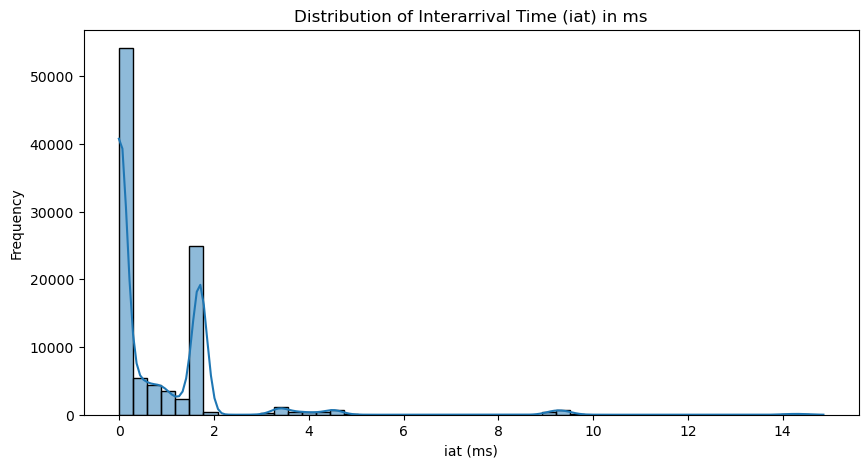

In [9]:
# Plot histogram of iat (latency proxy)
plt.figure(figsize=(10, 5))
sns.histplot(df_sample['iat'] * 1000, bins=50, kde=True)  # Convert to ms for readability
plt.title('Distribution of Interarrival Time (iat) in ms')
plt.xlabel('iat (ms)')
plt.ylabel('Frequency')
plt.show()

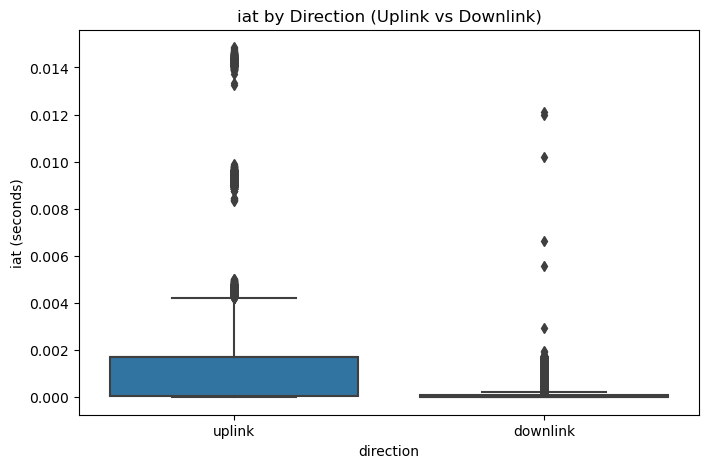

In [10]:
# Boxplot of iat by direction
plt.figure(figsize=(8, 5))
sns.boxplot(x='direction', y='iat', data=df_sample)
plt.title('iat by Direction (Uplink vs Downlink)')
plt.ylabel('iat (seconds)')
plt.show()

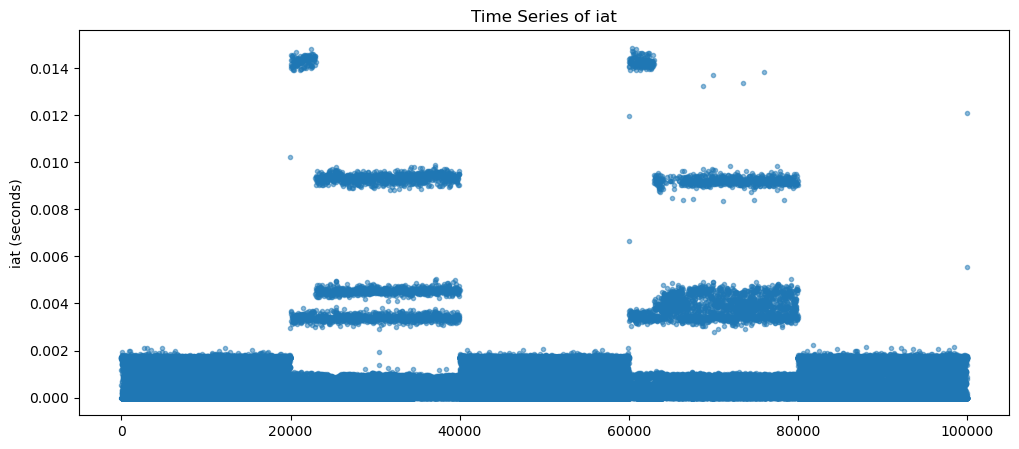

In [11]:
# Time-series plot of iat (resample if needed, but for sample: scatter)
plt.figure(figsize=(12, 5))
df_sample['iat'].plot(style='.', alpha=0.5)
plt.title('Time Series of iat')
plt.ylabel('iat (seconds)')
plt.show()